In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import socket
import importlib
import os
import sys

from pointnetvlad_eval_with_scores_arcore import *
from sklearn.neighbors import NearestNeighbors, KDTree


/home/jaybie/.conda/envs/mr-environment/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/srv/jaybie/archive/spatial-privacy-master/pointnetvlad_arcore_submaps/
Trajectories Loaded.
['ref_dataset_0', 'ref_dataset_1']
Training df for: ref_dataset_0
Training df for: ref_dataset_1


In [12]:
QUERY_PATH = 'pointnetvlad_arcore_submaps/'

RESULTS_FOLDER="testing_results/pointnetvlad/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   

# Step 3.1.1: One-time partial release case: inference using pointnetvlad

In [13]:
pickle_file = 'arcore_partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
        
    print(pickle_file,"exists; last item",results_pickle[-1][0])

except:
    print("No pickle file yet:",pickle_file)
    results_pickle = []
    
for radius in np.arange(0.25,3.1,0.25):
    
    query_fol = 'partial_radius_'+str(radius)
    
    QUERY_FILE = QUERY_PATH+'3d_{}_evaluation_query.pickle'.format(query_fol)
    
    output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'
    
    QUERY_SETS= get_sets_dict(QUERY_FILE)

    query_partial_path = os.path.join(QUERY_PATH,query_fol)

    df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')
    
    QUERY_DATABASE_NUMPY = np.asarray(df_test)
    
    print("Doing",QUERY_FILE,query_partial_path)
    
    ave_recall, ave_intra_dist, test_recall = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)
    
    print(len(test_recall))
    
    results_pickle.append([
            radius,
            ave_recall,
            ave_intra_dist,
            test_recall
    ])

    with open(RESULTS_FOLDER + pickle_file,'wb') as pickle_output:
        pickle.dump(results_pickle,pickle_output)

    

No pickle file yet: arcore_partial_results.pickle
Trajectories Loaded.
Doing pointnetvlad_arcore_submaps/3d_partial_radius_0.25_evaluation_query.pickle pointnetvlad_arcore_submaps/partial_radius_0.25
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(1000, 256)
0 0 Database output: (7927, 256) Queries output: (1000, 256)
1 0 Database output: (9439, 256) Queries output: (1000, 256)
 Average Inter-space Error: 0.8594999999999999
 Ave Intra-space Distance Error: 1.1754540435510512
 Average similarity: 0.9762814
2
Trajectories Loaded.
Doing pointnetvlad_arcore_submaps/3d_partial_radius_0.5_evaluation_query.pickle pointnetvlad_arcore_submaps/partial_radius_0.5
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(1000, 256)
0 

# Step 3.1.2: Results: One-time release case with pointnetVLAD (vs NN-matcher)

In [9]:
pickle_file = 'arcore_partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")

pointnetvlad_arcore = []

for radius, recall, intra_dist, test_recall in results_pickle:

    count_diff = 0

    for m, n, top1_obj_cands in test_recall:
        label_diff = top1_obj_cands[:,1] - top1_obj_cands[:,-1]
        count_diff += np.count_nonzero(label_diff==0)/len(top1_obj_cands)

    #count_diff/len(test_recall), count_diff/len(test_recall)+ave_recall[0]

    pointnetvlad_arcore.append([
        radius,
        recall[0],
        intra_dist[0],
        count_diff/len(test_recall)
    ])
    
pointnetvlad_arcore = np.asarray(pointnetvlad_arcore)

pickle_file = 'hololens_partial_results.pickle'
#RESULTS_FOLDER="testing_results/pointnetvlad_prod_2/"

try:
    with open("testing_results/pointnetvlad/" + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_hololens = []

for radius, recall, intra_dist, test_recall in results_pickle:

    count_diff = 0

    for m, n, top1_obj_cands in test_recall:
        label_diff = top1_obj_cands[:,0] - top1_obj_cands[:,1]
        count_diff += np.count_nonzero(label_diff==0)/len(top1_obj_cands)

    #count_diff/len(test_recall), count_diff/len(test_recall)+ave_recall[0]

    pointnetvlad_hololens.append([
        radius,
        recall[0],
        intra_dist[0],
        count_diff/len(test_recall)
    ])
    
pointnetvlad_hololens = np.asarray(pointnetvlad_hololens)

with open('testing_results/partial/results_partials_nn_matcher_1000.pickle', 'rb') as f:
    [results_partials, raw_errors, ransac_errors] = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/results_partials_nn_matcher.pickle", 'rb') as f:
    [arcore_results_partials, arcore_errors] = pickle.load(f)
    

/home/jaybie/.conda/envs/mr-environment/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


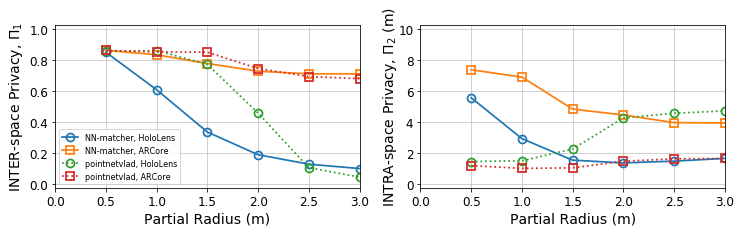

In [11]:
fig=plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Partial Radius (m)", fontsize = 14)

ax1.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax1.set_yticks(np.arange(0,1.1,0.2))
ax1.set_yticklabels(np.around(np.arange(0,1.1,0.2), decimals = 1),fontsize=12)

markersize = 8
linewidth = 1.75

RansacNN = np.asarray(results_partials[1])
ARCoreNN = np.asarray(arcore_results_partials)

ax1.plot(
    RansacNN[1::2,0],
    RansacNN[1::2,1],
    "-o",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, HoloLens"
)
ax1.plot(
    ARCoreNN[1::2,0],
    ARCoreNN[1::2,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)

ax1.plot(
    pointnetvlad_hololens[1::2,0],
    pointnetvlad_hololens[::2,1],
    ":o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, HoloLens"
)

ax1.plot(
    pointnetvlad_arcore[1::2,0],
    pointnetvlad_arcore[1::2,1],
    ":s",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, ARCore"
)

ax1.legend(loc = "lower left", ncol = 1, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14, labelpad = -1.0)
ax2.set_xlabel("Partial Radius (m)", fontsize = 14)

ax2.set_xticklabels(np.arange(0,3.1,0.5),fontsize=12)
ax2.set_yticks(np.arange(0,11,2))
ax2.set_yticklabels(np.arange(0,11,2),fontsize=12)

ax2.plot(
    RansacNN[1::2,0],
    RansacNN[1::2,2],
    '-o',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, HoloLens"
)
ax2.plot(
    ARCoreNN[1::2,0],
    ARCoreNN[1::2,2],
    '-s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, ARCore"
)
ax2.plot(
    pointnetvlad_hololens[1::2,0],
    pointnetvlad_hololens[1::2,2],
    ":o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, HoloLens"
)

ax2.plot(
    pointnetvlad_arcore[1::2,0],
    pointnetvlad_arcore[1::2,2],
    ":s",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad, ARCore"
)

#ax2.legend(loc = "center right", ncol = 1, fontsize = 8);
"""
plt.savefig('plots/partials-radius-with-arcore.png', format='png', dpi=300,bbox_inches = 'tight')
plt.savefig('plots/partials-radius-with-arcore.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
"""